In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import numpy as np
from tqdm import tqdm
import argparse
import wandb
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs
from model import *
from dataset import *
from utils import *
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
from collections import Counter


In [2]:
def visualize_images_torch(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    if len(images) == 1:
        axes = [axes]
    if images[0].shape[1] == 1:
        for ax, img in zip(axes, images):
            ax.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')  # Change channel order for matplotlib
            ax.axis('off')
        plt.show()
    else:
        for ax, img in zip(axes, images):
            ax.imshow(img.permute(2, 3, 1, 0).squeeze())  # Change channel order for matplotlib
            ax.axis('off')
        plt.show()

def visualize_images_numpy(images, is_grayscale=False):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    if len(images) == 1:
        axes = [axes]
    for ax, img in zip(axes, images):
        if is_grayscale:
            ax.imshow(img, cmap='gray')  # Set colormap to gray for grayscale images
        else:
            ax.imshow(img)  # Change channel order for RGB images
        ax.axis('off')
    plt.show()
    
def convert_to_grayscale(images):
    grayscale_images = []
    for img in images:
        grayscale_img = torch.mean(img.squeeze(), dim=0, keepdim=True)  # Take the mean across the RGB channels
        grayscale_images.append(grayscale_img)
    return grayscale_images

def edge_detection_canny(images, threshold1=100, threshold2=200):
    edge_images = []
    for img in images:
        img_np = img.squeeze().numpy()  # Convert torch tensor to numpy array
        img_np = (img_np * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        edges = cv2.Canny(img_np, threshold1, threshold2)  # Apply Canny edge detection
        edge_images.append(edges)
    return edge_images

def line_detection(edge_images, threshold=50, min_line_length=10, max_line_gap=5):
    line_images = []
    line_coords = []
    for edges in edge_images:
        img_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored lines
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(img_color, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green lines
                line_coords.append((x1, y1, x2, y2))
        line_images.append(img_color)
    return line_images, line_coords

# def check_repetitive_lines(line_coords, repetition_threshold=2):
#     lines_counter = Counter(line_coords)
#     for count in lines_counter.values():
#         if count >= repetition_threshold:
#             return 1
#     return 0

def check_repetitive_lines(line_coords, repetition_threshold=2, tolerance=5):
    def lines_equal(line1, line2, tol):
        return all(abs(a - b) <= tol for a, b in zip(line1, line2))

    line_counts = Counter()
    for line in line_coords:
        matched = False
        for existing_line in line_counts:
            if lines_equal(line, existing_line, tolerance):
                line_counts[existing_line] += 1
                matched = True
                break
        if not matched:
            line_counts[line] += 1

    for count in line_counts.values():
        if count >= repetition_threshold:
            return 1
    return 0

def detect_repetitive_lines(images, 
                            threshold1=100, 
                            threshold2=200, 
                            threshold=50, 
                            min_line_length=10, 
                            max_line_gap=5, 
                            repetition_threshold=1,
                            tolerance=5):

    # Convert RGB images to grayscale
    grayscale_images = convert_to_grayscale(images)
    # Perform Canny edge detection on grayscale images
    edge_images_canny = edge_detection_canny(grayscale_images, threshold1, threshold2)
    # Perform line detection on edge-detected images
    line_images, line_coords = line_detection(edge_images_canny, threshold, min_line_length, max_line_gap)
    # Check for repetitive lines
    result = check_repetitive_lines(line_coords, repetition_threshold, tolerance)
    
    return result

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
pos_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_pos/rgb_images/'
neg_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_neg/rgb_images/'

pos_dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_pos/dem/'
neg_dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_neg/dem/'

pos_gt_mask_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_pos/ground_truth/'
neg_gt_mask_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_neg/ground_truth/'

In [5]:
arg_batch_size = 1
learning_rate = 0.0001
epochs = 1
number_of_workers = 0
# image_size = arg_imagesize
val_percent = 0.0


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

full_dataset = SixImageDataset_DEM_GT(pos_dir, 
                             neg_dir, 
                             pos_dem_dir,
                             neg_dem_dir,
                             pos_gt_mask_dir,
                             neg_gt_mask_dir,
                             transform=transform)

In [6]:
n_val = int(len(full_dataset) * val_percent)
n_train = len(full_dataset) - n_val
train, val = random_split(full_dataset, [n_train, n_val])

train_loader = DataLoader(train, batch_size=arg_batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=arg_batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True, drop_last=True)
    

In [8]:
train_iter = iter(train_loader)

tensor([1.])


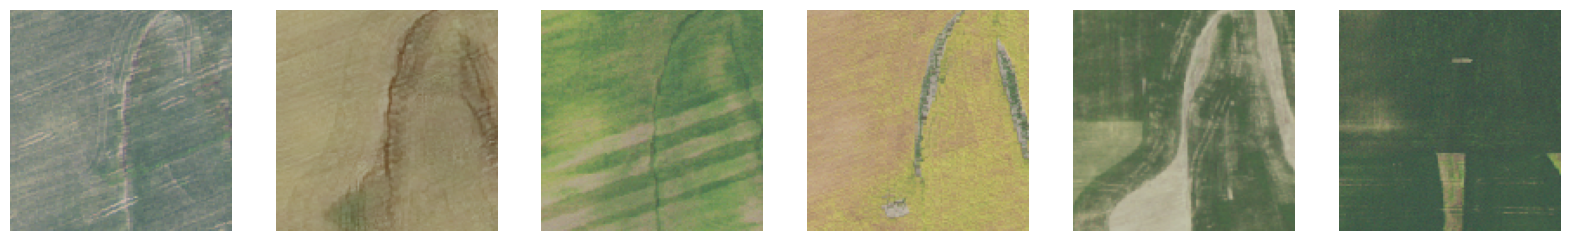

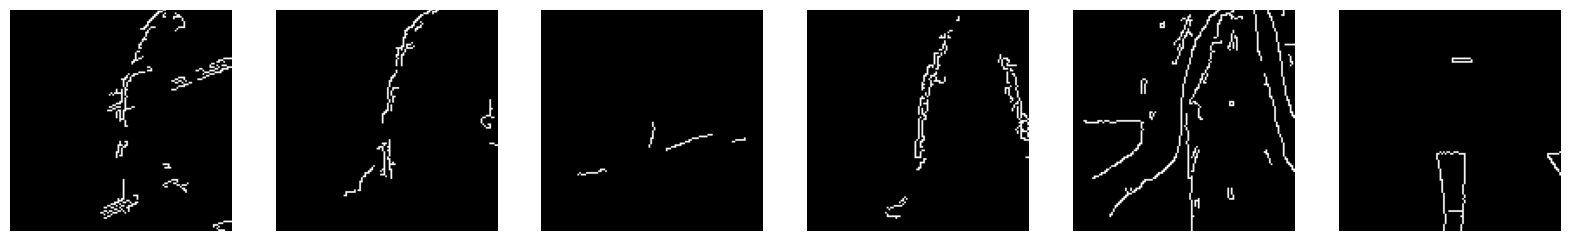

0

In [42]:
images, dem_images, gt_masks, labels = next(train_iter)
print(labels)
grayscale_images = convert_to_grayscale(images)
edge_images = edge_detection_canny(grayscale_images)
visualize_images_torch(images)
line_images, _ = line_detection(edge_images)
visualize_images_numpy(line_images)

detect_repetitive_lines(images,repetition_threshold=2, tolerance=10)

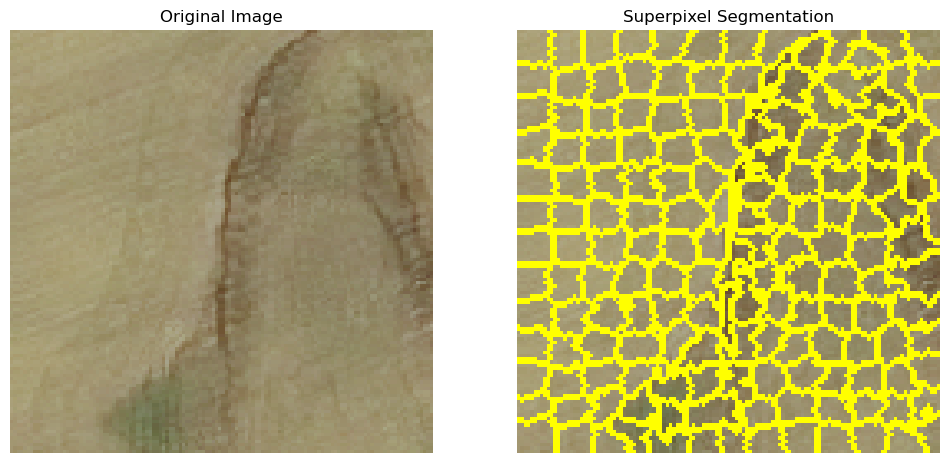

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation, color
from skimage.future import graph
from skimage.measure import label

def generate_superpixels(image, num_segments):
    """
    Generate superpixels from an input image using the SLIC algorithm.

    Parameters:
    - image_path: Path to the input image.
    - num_segments: The number of superpixels to generate.

    Returns:
    - segmented_image: The image with superpixel segmentation.
    """
    # Read the image
#     image = io.imread(image_path)

    # Apply the SLIC algorithm to segment the image into superpixels
    segments = segmentation.slic(image, n_segments=num_segments, compactness=10, start_label=1)

    # Create a border around each superpixel for visualization
#     segmented_image = color.label2rgb(segments, image, kind='avg', bg_label=0)
    segmented_image = segmentation.mark_boundaries(image, segments)
    
    return segmented_image, segments

def display_superpixels(original_image, segmented_image):
    """
    Display the original image and the image with superpixel segmentation side by side.

    Parameters:
    - original_image_path: Path to the original image.
    - segmented_image: The image with superpixel segmentation.
    """
#     original_image = io.imread(original_image_path)
    
    # Plot original and segmented images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(segmented_image)
    ax[1].set_title('Superpixel Segmentation')
    ax[1].axis('off')

    plt.show()

num_segments = 150  # Number of superpixels to generate

img = images[1].numpy().squeeze().transpose(1,2,0)
segmented_image, segments = generate_superpixels(img, num_segments)

# Display the original and segmented images
display_superpixels(img, segmented_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elingated ratio =  0.49
Round ratio =  0.1


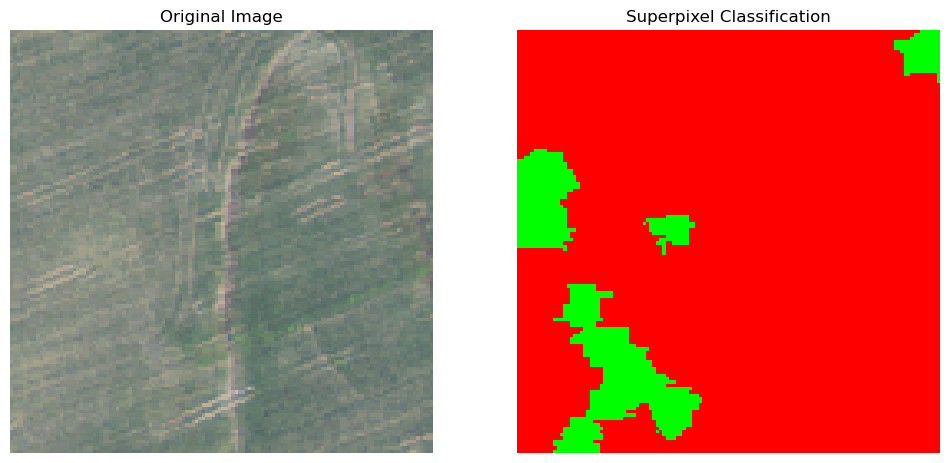

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elingated ratio =  0.3
Round ratio =  0.64


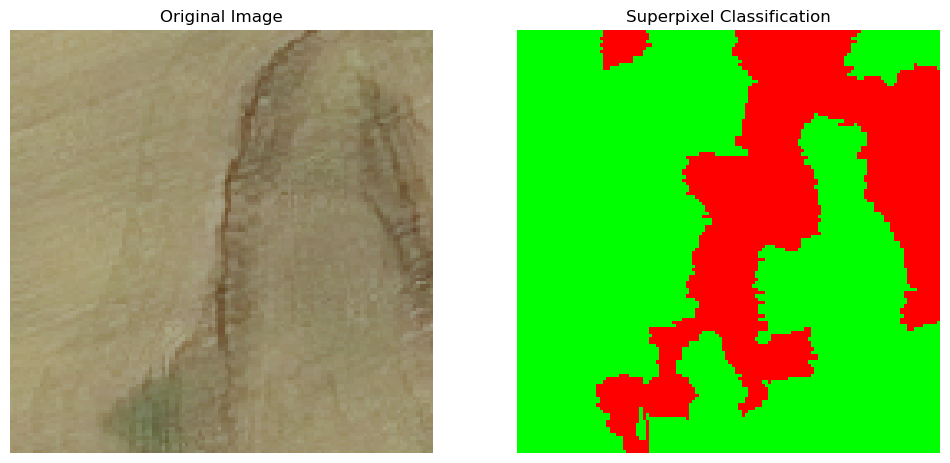

Elingated ratio =  0.57
Round ratio =  0.12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


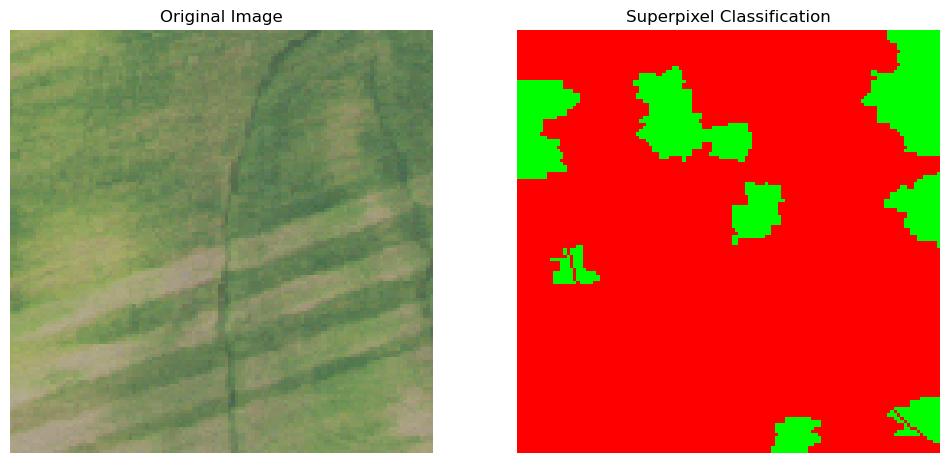

Elingated ratio =  0.53
Round ratio =  0.09


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


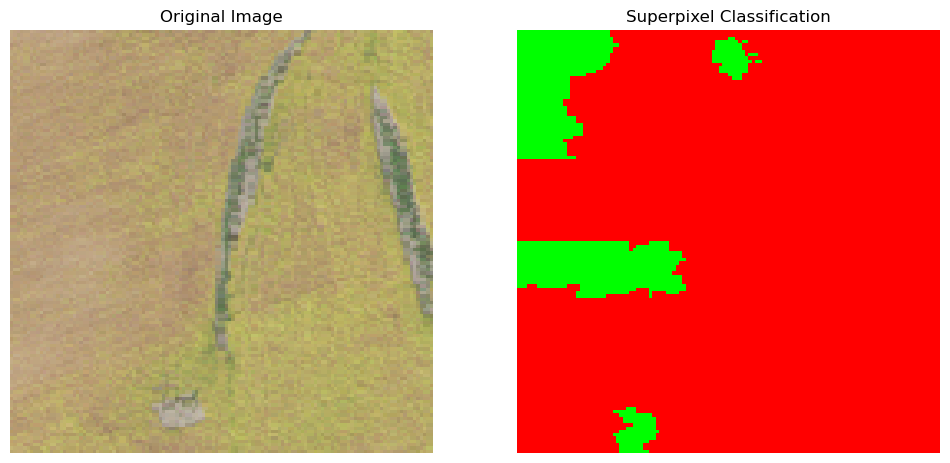

Elingated ratio =  0.61
Round ratio =  0.22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


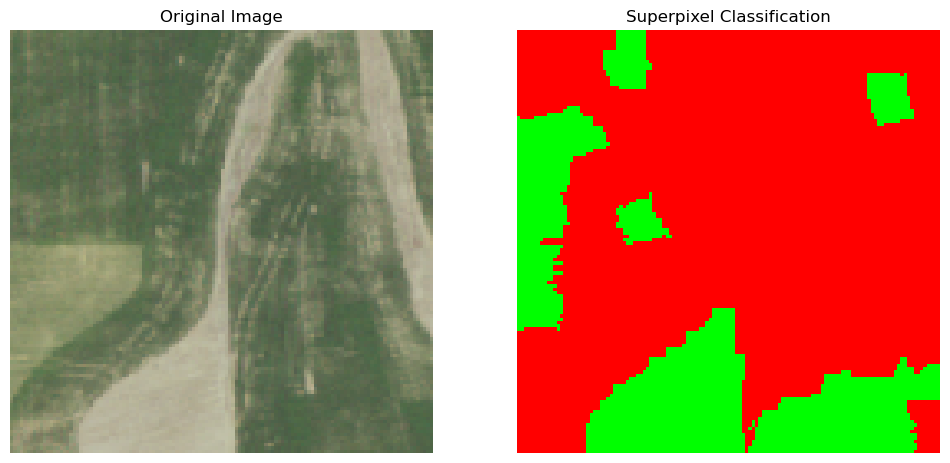

Elingated ratio =  0.45
Round ratio =  0.13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


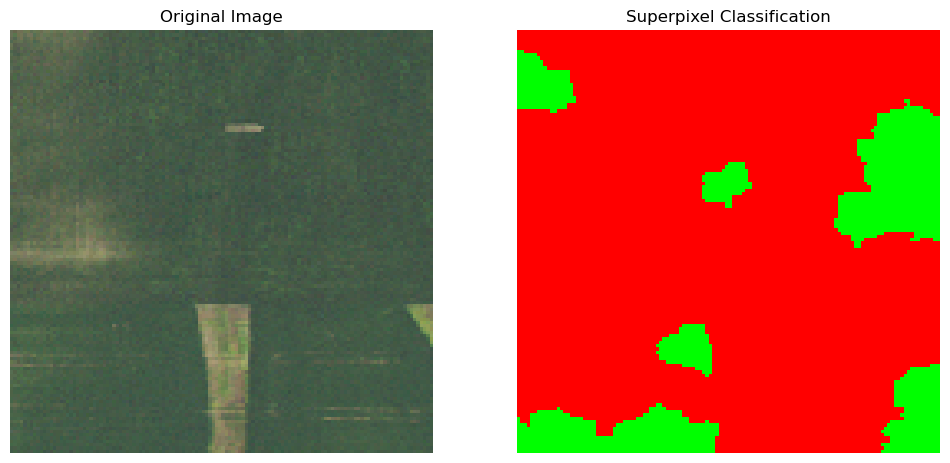

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, measure, morphology
from skimage.draw import polygon_perimeter
from skimage.measure import regionprops, label
from scipy.spatial import ConvexHull

def generate_superpixels(image, num_segments):
    """
    Generate superpixels from an input image using the SLIC algorithm.

    Parameters:
    - image: Input image (numpy array).
    - num_segments: The number of superpixels to generate.

    Returns:
    - segmented_image: The image with superpixel segmentation.
    - segments: The array of superpixel labels.
    """
    # Apply the SLIC algorithm to segment the image into superpixels
    segments = segmentation.slic(image, n_segments=num_segments, compactness=10, start_label=1)

    # Create a border around each superpixel for visualization
    segmented_image = segmentation.mark_boundaries(image, segments)
    
    return segmented_image, segments

def classify_superpixel_shape(segments, circularity_thresh=0.5, aspect_ratio_thresh=2.0):
    """
    Classify superpixels based on their shape into round or elongated.

    Parameters:
    - segments: The array of superpixel labels.

    Returns:
    - round_superpixels: List of labels for round superpixels.
    - elongated_superpixels: List of labels for elongated superpixels.
    """
    # Label the superpixel regions
    labeled_segments = label(segments)

    round_superpixels = []
    elongated_superpixels = []

    # Measure properties of each superpixel
    for region in regionprops(labeled_segments):
        # Get the coordinates of the superpixel's convex hull
        coords = region.coords
        if len(coords) < 3:
            continue  # Skip superpixels that are too small to analyze
        
        hull = ConvexHull(coords)
        
        # Calculate circularity: 4π * Area / Perimeter²
        area = region.area
        perimeter = region.perimeter
        circularity = (4 * np.pi * area) / (perimeter ** 2)
        
        # Calculate aspect ratio: Major axis length / Minor axis length
        aspect_ratio = region.major_axis_length / region.minor_axis_length if region.minor_axis_length > 0 else np.inf

        # Classify based on circularity and aspect ratio
        if circularity > circularity_thresh and aspect_ratio < aspect_ratio_thresh:
            round_superpixels.append(region.label)
        else:
            elongated_superpixels.append(region.label)

    return round_superpixels, elongated_superpixels

def display_superpixels_with_classification(original_image, segments, round_superpixels, elongated_superpixels):
    """
    Display the original image with the classified superpixels.

    Parameters:
    - original_image: The original input image.
    - segments: The superpixel segmentation.
    - round_superpixels: List of round superpixel labels.
    - elongated_superpixels: List of elongated superpixel labels.
    """
    # Create a copy of the original image to overlay the classifications
    image_with_classification = np.copy(original_image)

    # Mark round superpixels in green and elongated superpixels in red
    for region_label in round_superpixels:
        coords = np.argwhere(segments == region_label)
        rr, cc = polygon_perimeter(coords[:, 0], coords[:, 1], shape=image_with_classification.shape[:2], clip=True)
        image_with_classification[rr, cc] = [0, 255, 0]  # Green border for round superpixels

    for region_label in elongated_superpixels:
        coords = np.argwhere(segments == region_label)
        rr, cc = polygon_perimeter(coords[:, 0], coords[:, 1], shape=image_with_classification.shape[:2], clip=True)
        image_with_classification[rr, cc] = [255, 0, 0]  # Red border for elongated superpixels

    # Plot original and segmented images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(image_with_classification)
    ax[1].set_title('Superpixel Classification')
    ax[1].axis('off')

    plt.show()

# Number of superpixels to generate
num_segments = 100

for i in range(6):
    img = images[i].numpy().squeeze().transpose(1,2,0)
    # Assume `img` is your input image as a numpy array
    segmented_image, segments = generate_superpixels(img, num_segments)

    # Classify superpixels as round or elongated
    round_superpixels, elongated_superpixels = classify_superpixel_shape(segments, circularity_thresh=0.5,
                                                                         aspect_ratio_thresh=1.5)
    print("Elingated ratio = ", len(elongated_superpixels)/num_segments)
    print("Round ratio = ", len(round_superpixels)/num_segments)
    # Display the original and segmented images with classifications
    display_superpixels_with_classification(img, segments, round_superpixels, elongated_superpixels)


In [94]:
print("Round ratio = ", len(round_superpixels))

Round ratio =  187


In [95]:
len(elongated_superpixels)

152

In [154]:
detect_repetitive_lines(images)

0

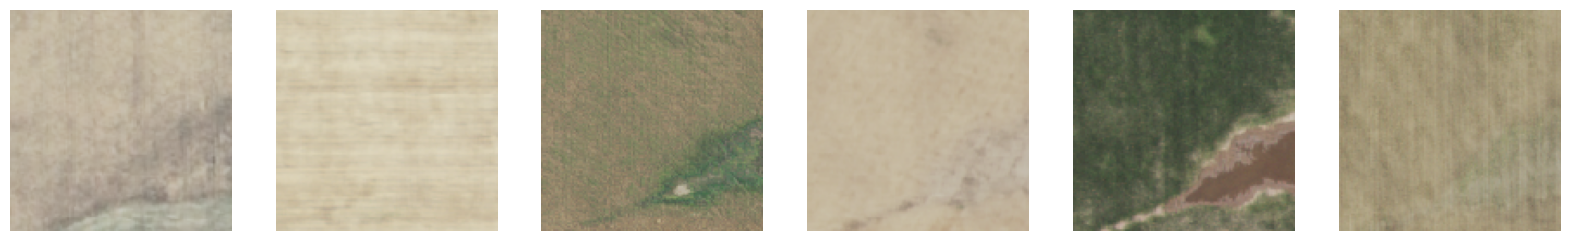

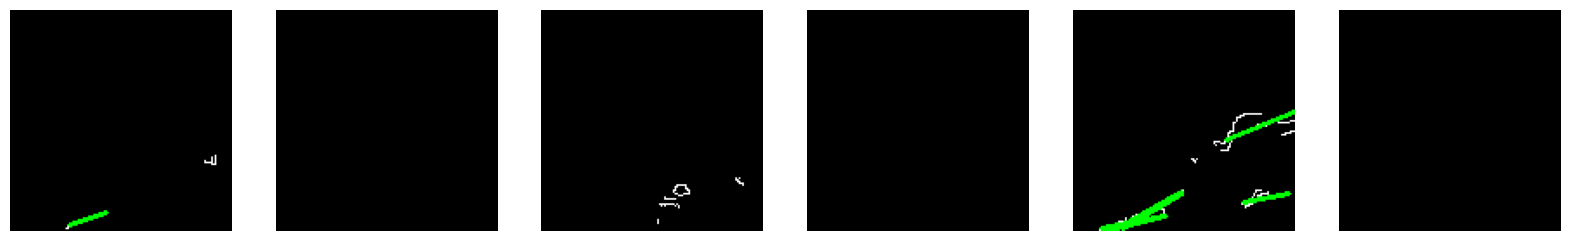